In [1]:
import matchup_calcs as mc
import tieraggregator as ta
from pokedex import Pokedex

dex = Pokedex()

I was a man on a mission. I wanted to prove that Moltres was underrated in Scarlet and Violet Overused. But how could I, a dude with a mid elo hovering in the 1400-1500 range ever properly make that argument to a higher ranked player?

A bunch of math. Because I'm a nerd. By professional training, I'm a data scientist. And I had to make sure that my method wouldn't just work for Moltres, it would have to work for *every* pokemon. And so I have learned how to definitivley quantify a pokemon's offensive and defensive weaknesses in relation to other pokemon.

Here's the basic model:

The Pokemon damage formula is pretty long, and it has the following parameters. I'm skipping the niche ones that only apply to a handful of pokemon, and the ones like level that are pretty much constant except for in a few niche cases.

1) Move power
2) Stats, using IVs and EVs
3) Weather
4) Crits
5) Random rolls
6) Burns
7) STAB
8) Type matchup

Out of these we can narrow in on a move power and stats as the only things that are really consistent from game to game because they're locked into the team builder. The dataset I got from the pokemon showdown API at https://play.pokemonshowdown.com/data/pokedex.json didn't contain movesets, so we're not counting those either.

What we're left with are the two things that basically every team is built around: a pokemon's typing and stats. But different pokemon have different matchups based on those types and stats! Blissey is very good at walling most special attackers, but is very weak into a physical fighting type. So we need our model to focus on individual offensive and defensive matchups. Step one of the model is figuring out how to generate metrics for two pokemon in a 1v1 scenario. 

Here's the basic formula:

 *1v1 score = type_matchup * attacker stat / defender stat / (defender hp/86.2)*

This formula gets you a score to measure the expected damage multiplier of the attacker vs the defender based on stats and typing, and then adjusts the survivability of the defender by their hp stat. A lower defensive score is better because it means in this matchup, the pokemon is expected to take less damage. A higher offensive score is better because it means that in this matchup, the pokemon is expected to deal more damage.

A caveat I need to mention: modeling the effects that speed has on a 1v1 scenario is really hard because it's situational. E.g. did the faster pokemon switch in and take a hit already? Is the faster pokemon revenge killing something? Etc. 

In [2]:
#Here are a few example matchups from the OU tier to help you understand how the scores work and what normal scores look like.

print('Great Tusk fighting Gholdengo')
print(mc.score_1v1_names('greattusk', 'gholdengo'))
print('Raging Bolt fighting Clodsire')
print(mc.score_1v1_names('ragingbolt', 'clodsire'))
print('Skarmory fighting Clefable')
print(mc.score_1v1_names('skarmory', 'clefable'))

#In a healthy tier most pokemon's numbers in any matchup will live somewhere between 0.5 and 2

Great Tusk fighting Gholdengo
{'Offense': 1.37, 'Defense': 1.88}
Raging Bolt fighting Clodsire
{'Offense': 0.45, 'Defense': 0.85}
Skarmory fighting Clefable
{'Offense': 1.49, 'Defense': 0.9}


Type matchup is the expected damage multiplier dealt based on the type matchup between the two pokemon. To make things easier, we're assuming that a pokemon is using a move of its type since I can't account for coverage moves easily. If the attacker is monotype this is pretty easy, but if there are dual types involved we average the expected outcomes. For example, if a Great Tusk [Ground, Fighting] is attacking a Gholdengo [Ghost, Steel], then the expected type score will be:

Ground -> [Ghost, Steel] = 2x
Fighting -> [Ghost, Steel] = 0x

[2 + 0] / 2 = 1, so we expect a type score of 1.

Then the attacker stat is the attacker's highest attacking stat, and the defender stat is the defensive stat that the defender is using to take the hit. In the actual damage formula the base damage of an attack is (Base Power)*(attacker stat/defender stat), so this part is ripped straight from the damage formula. In the above example, the attacker stat would be attack because Great Tusk is a physical attacker, and the defender stat is Gholdengo's physical defense. In the edge case where a pokemon's attack and special attack are exactly equal (like Kyurem), we calculate two seperate offense scores, one physical and one special, and then average the two final scores. I spent like an hour trying to figure out if Kyurem was stronger than Calyrex Ice because this edge case was a little annoying to figure out a formula for.

The last part of the 1v1 score is to adjust for the defender's HP stat. We divide the overall score by HP/86.2 because 86.2 is the average HP stat for all competitivley viable pokemon in gen 9 (meaning any pokemon in a tier PU or above, but not counting Ubers). Here are a couple of examples of why this is important. Ting-Lu is really bulky with an HP stat of 130, so we need to lower its defense score to show can take more damage than an average pokemon. 130/86.2 = 1.5, so we divide by 1.5 to lower the defense score. That's the same as reducing the defense score by 33%.  A pokemon like Deoxys-speed has a super low HP stat of 50, so we need to increase its defense score to show that it can take less damage than average. 50/86.2 = 0.58 and when you divide by a fraction, numbers get bigger. Dividing by 0.58 is the same as raising the defense score by 72%. Before I added in the HP stat modification, walls like Clodsire and Alomoloa with high HP but lower defenses would stick out as looking much less bulky than they actually are.



The next step is to show how pokemon generally match up against the rest of a tier. Doing this is pretty easy: you put the pokemon into a 1v1 matchup with every pokemon of a given tier and then average the scores you get. If a pokemon is evenly matched into a tier, its scores should generally between 0.75 defensivley and 1.5 offensivley on average against anything else in the tier.

In [3]:
#More Examples of things with varying power levels

#Kingambit has good offenses and is pretty bulky. It fits OU pretty well.
print('Kingambit vs the OU tier')
print(mc.poke_vs_tier('kingambit', 'OU'))

#Kyogre has broken offenses and is pretty bulky. It's banned for a reason!
print('Kyogre vs the OU tier')
print(mc.poke_vs_tier('kyogre', 'OU'))

#Frosmoth has good offenses but it can't switch into most pokemon. It's in PU for a reason.
print('Frosmoth vs OU')
print(mc.poke_vs_tier('frosmoth', 'OU'))

Kingambit vs the OU tier
{'Pokemon_Name': 'kingambit', 'Tier_Compared_To': 'OU', 'Avg_Defense': 0.92, 'Avg_Offense': 1.52}
Kyogre vs the OU tier
{'Pokemon_Name': 'kyogre', 'Tier_Compared_To': 'OU', 'Avg_Defense': 0.89, 'Avg_Offense': 2.06}
Frosmoth vs OU
{'Pokemon_Name': 'frosmoth', 'Tier_Compared_To': 'OU', 'Avg_Defense': 2.88, 'Avg_Offense': 1.74}


Now let's take a look at graphs!

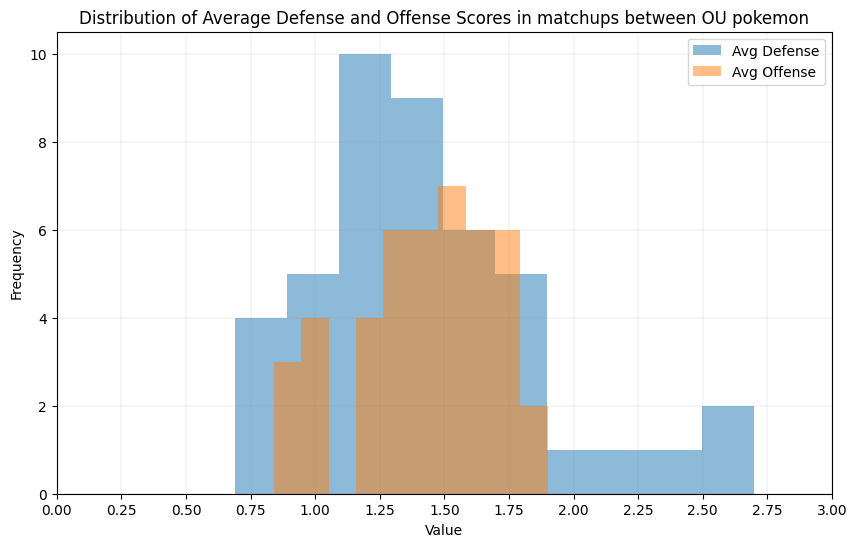

In [4]:
ou_matchups = ta.tier_vs_tier('OU', 'OU')

import matplotlib.pyplot as plt
import numpy as np

# Extract Avg_Defense and Avg_Offense values from ou_matchups
avg_defense_ou = [matchup['Avg_Defense'] for matchup in ou_matchups]
avg_offense_ou = [matchup['Avg_Offense'] for matchup in ou_matchups]

# Plotting
plt.figure(figsize=(10, 6))

# Histogram for Avg_Defense
plt.hist(avg_defense_ou, bins = 10, alpha=0.5, label='Avg Defense')

# Histogram for Avg_Offense
plt.hist(avg_offense_ou, bins = 10, alpha=0.5, label='Avg Offense')

plt.title('Distribution of Average Defense and Offense Scores in matchups between OU pokemon')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

#changing tick marks
min_value = min(min(avg_defense_ou), min(avg_offense_ou))
max_value = max(max(avg_defense_ou), max(avg_offense_ou))
plt.xticks(np.arange(np.floor(min_value), np.ceil(max_value) + 0.25, 0.25))

# Enhancing grid visibility
plt.grid(True, linewidth=0.1, color='grey')

plt.show()


As you can see here: It's pretty average for an OU pokemon to have an average score into other OU pokemon that looks like Defense: 1.5, Offense, 1.5

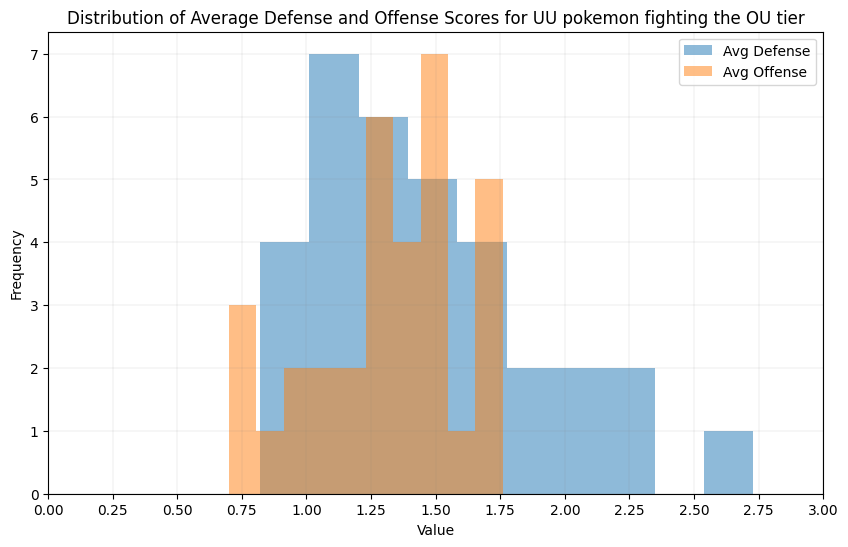

In [5]:
uu_matchups = ta.tier_vs_tier('UU', 'OU')

# Extract Avg_Defense and Avg_Offense values from ou_matchups
avg_defense_uu = [matchup['Avg_Defense'] for matchup in uu_matchups]
avg_offense_uu = [matchup['Avg_Offense'] for matchup in uu_matchups]

# Plotting
plt.figure(figsize=(10, 6))

# Histogram for Avg_Defense
plt.hist(avg_defense_uu, alpha=0.5, label='Avg Defense')

# Histogram for Avg_Offense
plt.hist(avg_offense_uu, alpha=0.5, label='Avg Offense')

plt.title('Distribution of Average Defense and Offense Scores for UU pokemon fighting the OU tier')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

#changing tick marks
min_value = min(min(avg_defense_uu), min(avg_offense_uu))
max_value = max(max(avg_defense_uu), max(avg_offense_uu))
plt.xticks(np.arange(np.floor(min_value), np.ceil(max_value) + 0.25, 0.25))

# Enhancing grid visibility
plt.grid(True, linewidth=0.1, color='grey')

plt.show()

But if take the UU pokemon and see how they stack up on average into OU threats, you can see numerically that they have a harder time. Most UU pokemon have an average offense score below 1.5, and about half of them have a defense score of 1.5 or higher. Their stats and typings on average don't work as well.

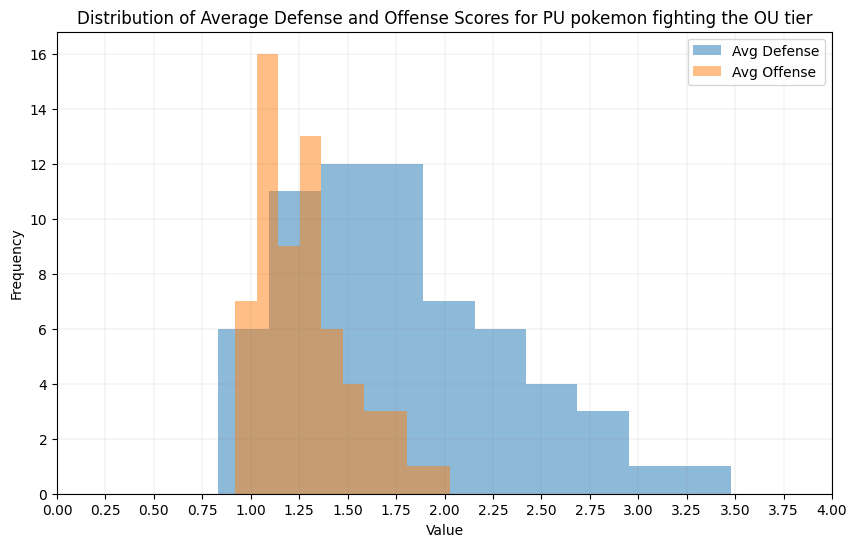

In [6]:
pu_matchups = ta.tier_vs_tier('PU', 'OU')

# Extract Avg_Defense and Avg_Offense values from ou_matchups
avg_defense_pu = [matchup['Avg_Defense'] for matchup in pu_matchups]
avg_offense_pu = [matchup['Avg_Offense'] for matchup in pu_matchups]

# Plotting
plt.figure(figsize=(10, 6))

# Histogram for Avg_Defense
plt.hist(avg_defense_pu, alpha=0.5, label='Avg Defense')

# Histogram for Avg_Offense
plt.hist(avg_offense_pu, alpha=0.5, label='Avg Offense')

plt.title('Distribution of Average Defense and Offense Scores for PU pokemon fighting the OU tier')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

#changing tick marks
min_value = min(min(avg_defense_pu), min(avg_offense_pu))
max_value = max(max(avg_defense_pu), max(avg_offense_pu))
plt.xticks(np.arange(np.floor(min_value), np.ceil(max_value) + 0.25, 0.25))

# Enhancing grid visibility
plt.grid(True, linewidth=0.1, color='grey')

plt.show()

And we can see that most PU pokemon have an offense score below 1.5 and a defense score above 1.5, PU pokemon have it rough and that's why none of them are in OU!

And now for arguments about a few individual pokemon.

This entire data science project was about Moltres. I think it's a good pokemon in gen 9 OU. It has good bulk, a good typing both offensivley and defensivley, and it matches up extremley well into Kingambit, Great Tusk, Iron Valiant, and Gholdengo. And, on top of all that, Moltres slots onto offense teams alongside kingambit extremely easily. Moltres, Kingabmit, and any grass/dragon type is enough to have a viable switch in to the entire type chart! Moltres also has a lot of set flexibility: it's a great burn spreader with flame body, willow wisp, and scorching sands while also having u-turn, roost and the great offensive combination of flying, fire, ground, and rock coverage to pick and choose from. It's a highly customizeable bulky pivot pokemon for offense teams that partners extremely well with the best pokemon in the tier!

Can I numerically prove that Moltres is good in OU? Yes. Moltres, in terms of stats and typing, performs very well in OU with a defense score of 1.18 and an offense score of 1.65, it performs better than some of the tier's offensive and defensive staples on average into the metagame at large.

In [7]:
print(mc.poke_vs_tier("moltres", "OU"))

{'Pokemon_Name': 'moltres', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.17, 'Avg_Offense': 1.65}


Another pokemon I'd like to bring up is Keldeo. Keldeo is a good pokemon and literally everyone knows that. But in past generations because of the presence of universal walls like Toxapex, mixed with fierce competition from Urshifu Rapid, Keldo has had a hard time seeing usage in OU. But now Keldeo has vaccum wave, urshifu is gone, toxapex sucks, and Clodsire mostly sees use on stall. I think that Keldeo is still being overlooked because of the past two gens.

Keldeo faces good competition from Walking Wake and Ogerpon-Wellspring for the speedy offensive water type slot on a team, but Keldeo has enough distinct advantages to stand out and have a great niche in OU. Its fighting type and unique access to a strong special attacking priority move give Keldeo a niche that no other pokemon can fill, and Keldeo will feel very at home on many OU teams. 

Numerically, Keldeo has good defenses for the tier and a stellar Offense score of 1.76, Keldeo needs to see more usage.

In [8]:
print(mc.poke_vs_tier("keldeo", "OU"))
print(mc.poke_vs_tier("walkingwake", "OU"))
print(mc.poke_vs_tier("ogerponwellspring", "OU"))

{'Pokemon_Name': 'keldeo', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.29, 'Avg_Offense': 1.76}
{'Pokemon_Name': 'walkingwake', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.11, 'Avg_Offense': 1.57}
{'Pokemon_Name': 'ogerponwellspring', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.34, 'Avg_Offense': 1.37}


And finally, Kyurem. At first, I didn't think Kyruem deserved a suspect test. I didn't even think about Kyurem once while making this data set. But then I saw Kyurem's scores and I wanted to cry.

In [9]:
print('Kyurem vs OU')
print(mc.poke_vs_tier("kyurem", "OU"))
print('Kyurem vs Ubers')
print(mc.poke_vs_tier('kyurem', 'Uber'))
print('Calyrex-Ice vs OU')
print(mc.poke_vs_tier("CalyrexIce", "ou"))

Kyurem vs OU
{'Pokemon_Name': 'kyurem', 'Tier_Compared_To': 'OU', 'Avg_Defense': 1.08, 'Avg_Offense': 1.67}
Kyurem vs Ubers
{'Pokemon_Name': 'kyurem', 'Tier_Compared_To': 'Uber', 'Avg_Defense': 1.33, 'Avg_Offense': 1.71}
Calyrex-Ice vs OU
{'Pokemon_Name': 'CalyrexIce', 'Tier_Compared_To': 'ou', 'Avg_Defense': 0.92, 'Avg_Offense': 1.93}


Kyurem's numbers are kind of stupid, but they're not really an accurate representation. If you treat Kyurem as a special attacker, he has an offense score of 1.75 into OU. 